# Import

In [107]:
import pandas as pd
import os
from matplotlib import pyplot as plt

In [108]:
# Get the current file's directory
current_dir = ocurrent_dir = os.getcwd()

project_root = os.path.dirname(current_dir)

data_dir = os.path.join(project_root, 'data')
customers_file = os.path.join(data_dir, 'customers_raw.csv')
complaints_file = os.path.join(data_dir, 'complaints_raw.csv')

customers_df = pd.read_csv(customers_file)
complaints_df = pd.read_csv(complaints_file)

# Clean

In [86]:
# #inspect unique values and missing values

# for col in customers_df.columns:
#     print('----\n', customers_df[col].value_counts(), '\n\n', customers_df[col].isna().sum())

In [87]:
# New customers have positive monthly charges but no total charges.
customers_df.loc[customers_df['TotalCharges'] == ' ', 'TotalCharges'] = customers_df.loc[customers_df['TotalCharges'] == ' ', 'MonthlyCharges']

In [88]:
## Customer's data

# Column names and variable types
customers_df = customers_df.rename(columns={'customerID': 'CustomerId', 'tenure':'Tenure', 'gender':'Gender'})
customers_df['CustomerId'] = customers_df['CustomerId'].astype(str)
customers_df['Gender'] = customers_df['Gender'].astype(str)
customers_df['SeniorCitizen'] = customers_df['SeniorCitizen'].astype(int)
customers_df['Dependents'] = customers_df['Dependents'].astype(str).map({'No':0, 'Yes':1})
customers_df['Tenure'] = customers_df['Tenure'].astype(int)
customers_df['PhoneService'] = customers_df['PhoneService'].astype(str).map({'No':0, 'Yes':1})
customers_df['MultipleLines'] = customers_df['MultipleLines'].astype('category')
customers_df['InternetService'] = customers_df['InternetService'].astype('category')
customers_df['OnlineSecurity'] = customers_df['OnlineSecurity'].astype('category')
customers_df['OnlineBackup'] = customers_df['OnlineBackup'].astype('category')
customers_df['DeviceProtection'] = customers_df['DeviceProtection'].astype('category')
customers_df['TechSupport'] = customers_df['TechSupport'].astype('category')
customers_df['StreamingTV'] = customers_df['StreamingTV'].astype('category')
customers_df['StreamingMovies'] = customers_df['StreamingMovies'].astype('category')
customers_df['Contract'] = customers_df['Contract'].astype('category')
customers_df['ContractLengthMonths'] = customers_df['Contract'].astype(str).map({'Month-to-month':1, 'One year':12, 'Two year':24})
customers_df = customers_df.drop(columns=['Contract'])
customers_df['PaperlessBilling'] = customers_df['PaperlessBilling'].astype(str).map({'No':0, 'Yes':1})
customers_df['PaymentMethod'] = customers_df['PaymentMethod'].astype('category')
customers_df['MonthlyCharges'] = customers_df['MonthlyCharges'].astype(float)
customers_df['TotalCharges'] = customers_df['TotalCharges'].astype(float)
customers_df['Churn'] = customers_df['Churn'].astype(str).map({'No':0, 'Yes':1})

# convert to one hot encoding
categorical_columns = customers_df.select_dtypes(include=['category']).columns

# Create one-hot encoding for each categorical column
for column in categorical_columns:
    # Create dummy variables and add prefix with column name
    dummies = pd.get_dummies(customers_df[column], prefix=column)
    
    # Add dummy columns to dataframe
    customers_df = pd.concat([customers_df, dummies], axis=1)
    
    # Drop the original categorical column
    customers_df = customers_df.drop(column, axis=1)

In [89]:
## Complaints data

# Column names and variable types
complaints_df = complaints_df.rename(columns={'customerID': 'CustomerId', 'complaint':'Complaint', 'complaint_number':'ComplaintNumber'})
complaints_df['CustomerId'] = complaints_df['CustomerId'].astype(str)
complaints_df['Complaint'] = complaints_df['Complaint'].astype(str)
complaints_df['ComplaintNumber'] = complaints_df['ComplaintNumber'].astype(int)

# Eng. features

check if recording date of user is before or after monthly charge

In [90]:
## Customer df

# 1. ChangedPlan
customers_df['ChangedPlan'] = 0
expected_total = customers_df['Tenure'] * customers_df['MonthlyCharges']
customers_df.loc[customers_df['TotalCharges'] != expected_total, 'ChangedPlan'] = 1

# 2. ChangedPlanPositive
customers_df['ChangedPlanPositive'] = 0
customers_df.loc[customers_df['TotalCharges'] < expected_total, 'ChangedPlanPositive'] = 1

# 3. ChangedPlanNegative
customers_df['ChangedPlanNegative'] = 0
customers_df.loc[customers_df['TotalCharges'] > expected_total, 'ChangedPlanNegative'] = 1

# 4. InternetServicesDensity
# First, get all service columns
internet_services_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                             'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count services that are not "No" and divide by 7
# Define the internet services columns after one-hot encoding
internet_services_binary = [col for col in customers_df.columns if any(service in col for service in [
    'OnlineSecurity_Yes',
    'OnlineBackup_Yes',
    'DeviceProtection_Yes',
    'TechSupport_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes'
])]

# Calculate the density using the binary columns
customers_df['InternetServicesDensity'] = customers_df[internet_services_binary].sum(axis=1) / len(internet_services_binary)

# # 6. ContractLifecycle
# customers_df['ContractLifecycle'] = customers_df.apply(
#     lambda row: (row['Tenure'] % row['ContractLengthMonths']) / row['ContractLengthMonths'], 
#     axis=1
# )

In [91]:
from textblob import TextBlob
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()

    # Handle contractions
    text = text.replace("'m", " am")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'s", " is")
    text = text.replace("'ll", " will")
    text = text.replace("'ve", " have")
    text = text.replace("'d", " would")

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Function to get key terms by POS tag for churned customers
def get_key_terms_by_pos(complaints_df, customers_df, pos_tag_type, top_n=10):
    # Merge complaints with customer data
    merged_df = pd.merge(complaints_df, customers_df[['CustomerId', 'Churn']], on='CustomerId', how='left')
    
    # Get complaints from churned customers
    churned_complaints = merged_df[merged_df['Churn'] == 0]['Complaint'].dropna()
    
    # Process all complaints
    processed_complaints = [preprocess_text(text) for text in churned_complaints]
    
    # Get all words with specified POS tag
    key_terms = []
    for text in processed_complaints:
        # POS tag the text
        tagged = pos_tag(word_tokenize(text))
        # Extract words with matching POS tag
        if pos_tag_type == 'NOUN':
            pos_filter = ['NN', 'NNS', 'NNP', 'NNPS']
        elif pos_tag_type == 'VERB':
            pos_filter = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
        elif pos_tag_type == 'ADJ':
            pos_filter = ['JJ', 'JJR', 'JJS']
        
        key_terms.extend([word.lower() for word, tag in tagged if tag in pos_filter])
    
    # Get most common terms
    return [word for word, _ in Counter(key_terms).most_common(top_n)]

def count_terms(text, terms):
    if not text:
        return 0
    words = text.split()
    return sum(words.count(term) for term in terms)


# Create the features

# 0. ProcessedComplaint
complaints_df['ProcessedComplaint'] = complaints_df['Complaint'].fillna('').apply(preprocess_text)

# 1. ComplaintLength
complaints_df['ComplaintLength'] = complaints_df['Complaint'].fillna('').str.len()

# Get key terms for churned customers
key_nouns = get_key_terms_by_pos(complaints_df, customers_df, 'NOUN')
key_verbs = get_key_terms_by_pos(complaints_df, customers_df, 'VERB')
key_adjectives = get_key_terms_by_pos(complaints_df, customers_df, 'ADJ')

# Process complaints
processed_complaints = complaints_df['ProcessedComplaint']


# 2. Sentiment
complaints_df['Sentiment'] = complaints_df['Complaint'].fillna('').apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

# 3. KeyVerbsCount
complaints_df['KeyVerbsCount'] = processed_complaints.apply(
    lambda x: count_terms(x, key_verbs)
)

# 4. KeyNounsCount
complaints_df['KeyNounsCount'] = processed_complaints.apply(
    lambda x: count_terms(x, key_nouns)
)

# 5. KeyAdjectivesCount
complaints_df['KeyAdjectivesCount'] = processed_complaints.apply(
    lambda x: count_terms(x, key_adjectives)
)

[nltk_data] Downloading package punkt to /Users/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [92]:
# anger df for anger score calculation
anger_df = complaints_df.copy()
max_complaint_number = anger_df.groupby('CustomerId')['ComplaintNumber'].aggregate('max')
anger_df = anger_df.merge(max_complaint_number, on=['CustomerId', 'ComplaintNumber'], how='inner')[['CustomerId', 'ComplaintNumber', 'Complaint']]

## pipeline to compute anger score with gen ai
# ..
# -> anger_df_result

In [93]:
# compacting complaints into one column to have one row per customer
compacted_complanits_df = anger_df.groupby('CustomerId').aggregate({'Complaint': ' '.join}).reset_index()
# compacted_complanits_df['AngerScore'] = anger_df_result['AngerScore'].values  


# Merged

In [94]:
merdged_df = pd.merge(customers_df, compacted_complanits_df, on='CustomerId', how='left')
merdged_df['HasComplaint'] = merdged_df['Complaint'].notna().astype(int)

question: how to merge complaints with customer data when a user has more than one complaint?
solution: compute anger score for the last complaint, append all complaints into into one,

# Save CSV

In [99]:
complaints_df.to_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/complaints_processed.csv', index=False)
customers_df.to_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/customers_processed.csv', index=False)
merdged_df.to_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/customers_complaints_merdged.csv', index=False)
anger_df.to_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/complaitns_for_anger.csv', index=False)

# Part 5

In [109]:
df = pd.read_csv('/Users/marco/Documents/python_projects/churn_bcgx/data/customers_with_churn_probabilities.csv')
df = df[df['Churn'] == 0]

In [144]:
print(df[(df['InternetService_Fiber optic']==1)]['MonthlyCharges'].sum())

168984.34999999998


## Analysis
Of users who have not yet churned

<Axes: >

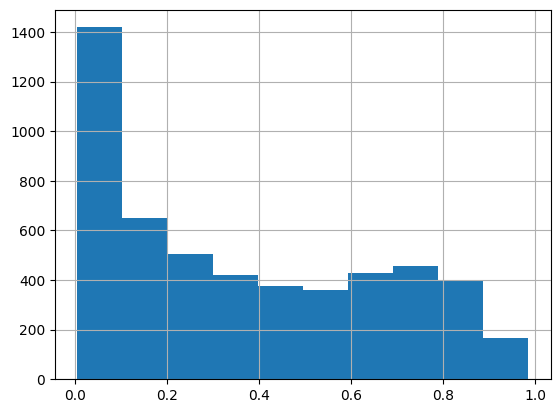

In [111]:
df['ChurnProbability'].hist()

In [112]:
df['ChurnProbability'].describe()

count    5174.000000
mean        0.367377
std         0.288490
min         0.004306
25%         0.092854
50%         0.302496
75%         0.635452
max         0.984801
Name: ChurnProbability, dtype: float64

In [113]:
df['Expected Loss'] = (df['ChurnProbability'] * df['MonthlyCharges']).round(2)

money_1 = (df
    .groupby('RiskCategory')
    .agg({
            'CustomerId' : 'count',
            'MonthlyCharges' : 'mean', 
            'ChurnProbability' : 'mean',
            'Expected Loss' : 'sum',
            'TotalCharges' : 'mean'})
    .rename(columns={
            'CustomerId' : 'Customer Count', 
            'MonthlyCharges' : 'Avg Monthly',
            'ChurnProbability' : 'Avg Churn Prob',
            'Expected Loss' : 'Total Expected Loss',
            'TotalCharges' : 'Avg Total'})
    .map(round, ndigits=2)
    .reset_index())

money_2 = (df
    .groupby('RiskCategory')
    .agg({'MonthlyCharges' : 'sum', 'TotalCharges' : 'sum'})
    .rename(columns={
            'CustomerId' : 'Customer Count', 
            'MonthlyCharges' : 'Sum Monthly',
            'TotalCharges' : 'Sum Total'})
    .map(round, ndigits=2)
    .reset_index())

money_df = money_1.merge(money_2, on=['RiskCategory'])
money_df['Risk Category'] = ['High Risk', 'Low Risk', 'Medium Risk']
money_df = money_df[['Risk Category', 'Avg Churn Prob', 'Customer Count', 'Avg Monthly', 'Sum Monthly', 'Avg Total', 'Sum Total', 'Total Expected Loss']]

money_df

,Risk Category,Avg Churn Prob,Customer Count,Avg Monthly,Sum Monthly,Avg Total,Sum Total,Total Expected Loss
0,High Risk,0.81,968,75.33,72918.70,1551.51,1501866.35,59333.85
1,Low Risk,0.11,2579,52.64,135750.45,2907.02,7497204.75,17250.24
2,Medium Risk,0.50,1627,66.57,108316.60,2578.14,4194626.30,54979.79


In [125]:
statistics_df =(df
    .groupby('RiskCategory')
    .agg({
        'SeniorCitizen':'mean',
        'PaymentMethod_Bank transfer (automatic)' : 'mean',
        'PaymentMethod_Credit card (automatic)' : 'mean',
        'anger_score' : 'mean',
        'HasComplaint' : 'mean',
        'ContractLengthMonths': 'mean',
        'InternetService_Fiber optic' : 'mean',
        'InternetServicesDensity' : 'mean',
        'InternetService_No' : 'mean'
    })
    .map(round, ndigits=2)
    .reset_index())

statistics_df

# also supported by partial dependency plots

,RiskCategory,SeniorCitizen,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),anger_score,HasComplaint,ContractLengthMonths,InternetService_Fiber optic,InternetServicesDensity,InternetService_No
0,High Risk,0.24,0.11,0.12,0.73,0.13,1.50,0.72,0.28,0.04
1,Low Risk,0.08,0.31,0.32,0.16,0.03,18.43,0.17,0.37,0.43
2,Medium Risk,0.15,0.24,0.22,0.25,0.05,5.20,0.42,0.38,0.16


## Recommendations

In [115]:
df_high = df[df['RiskCategory'] == 'High Risk'].copy()
df_high.describe()

,SeniorCitizen,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score,ChurnProbability,Expected Loss
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.0,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,0.236570,0.172521,17.492769,0.934917,0.755165,75.329236,1551.514824,0.0,1.497934,0.838843,0.440083,0.398760,0.281508,0.130165,0.729769,0.810937,61.295300
std,0.425196,0.378028,17.438915,0.246799,0.430211,23.144711,1726.585081,0.0,2.793477,0.367866,0.496654,0.489896,0.233953,0.336659,1.915025,0.068869,19.796998
min,0.000000,0.000000,1.000000,0.000000,0.000000,19.250000,19.250000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700268,13.880000
25%,0.000000,0.000000,3.000000,1.000000,1.000000,59.900000,178.937500,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.749355,48.360000
50%,0.000000,0.000000,11.000000,1.000000,1.000000,80.000000,850.450000,0.0,1.000000,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.807680,65.425000
75%,0.000000,0.000000,28.000000,1.000000,1.000000,93.600000,2414.900000,0.0,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,0.866474,75.860000
max,1.000000,1.000000,70.000000,1.000000,1.000000,115.050000,7554.050000,0.0,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.984801,103.550000


In [116]:
df_medium = df[df['RiskCategory'] == 'Medium Risk'].copy()
df_medium.describe()

,SeniorCitizen,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score,ChurnProbability,Expected Loss
count,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.0,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000,1627.000000
mean,0.148125,0.280270,31.778119,0.877074,0.611555,66.574431,2578.135403,0.0,5.199754,0.954518,0.474493,0.480025,0.379430,0.045482,0.245493,0.503826,33.792127
std,0.355333,0.449269,21.807738,0.328453,0.487546,29.749611,2323.077928,0.0,6.479701,0.208424,0.499502,0.499754,0.284729,0.208424,1.131641,0.120903,17.511282
min,0.000000,0.000000,1.000000,0.000000,0.000000,18.850000,18.850000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300194,5.990000
25%,0.000000,0.000000,12.000000,1.000000,0.000000,44.850000,513.700000,0.0,1.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.394724,19.960000
50%,0.000000,0.000000,29.000000,1.000000,1.000000,68.550000,1837.900000,0.0,1.000000,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.502065,32.340000
75%,0.000000,1.000000,51.000000,1.000000,1.000000,94.100000,4450.800000,0.0,12.000000,1.000000,1.000000,1.000000,0.666667,0.000000,0.000000,0.610533,47.405000
max,1.000000,1.000000,72.000000,1.000000,1.000000,117.200000,8309.550000,0.0,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.699935,76.450000


In [117]:
df_low = df[df['RiskCategory'] == 'Low Risk'].copy()
df_low.describe()

,SeniorCitizen,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ContractLengthMonths,ChangedPlan,ChangedPlanPositive,ChangedPlanNegative,InternetServicesDensity,HasComplaint,anger_score,ChurnProbability,Expected Loss
count,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.0,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000
mean,0.075998,0.450174,48.759597,0.903451,0.405196,52.636855,2907.020066,0.0,18.426522,0.998837,0.490888,0.507949,0.368941,0.030632,0.157813,0.114811,6.688732
std,0.265047,0.497608,21.330028,0.295400,0.491025,31.846498,2422.376944,0.0,7.407480,0.034093,0.500014,0.500034,0.371045,0.172352,0.890460,0.081018,7.111706
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004306,0.080000
25%,0.000000,0.000000,32.000000,1.000000,0.000000,20.350000,859.325000,0.0,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050510,1.510000
50%,0.000000,0.000000,55.000000,1.000000,0.000000,51.250000,1885.150000,0.0,24.000000,1.000000,0.000000,1.000000,0.333333,0.000000,0.000000,0.091909,3.790000
75%,0.000000,1.000000,68.000000,1.000000,1.000000,80.125000,4789.975000,0.0,24.000000,1.000000,1.000000,1.000000,0.666667,0.000000,0.000000,0.168179,9.245000
max,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8672.450000,0.0,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.299927,34.520000


In [118]:
df_complaints = df[df['HasComplaint'] == 1]
df_complaints.groupby('RiskCategory').agg({'CustomerId' : 'count', 'anger_score' : 'mean'})

,CustomerId,anger_score
RiskCategory,,
High Risk,126,5.606481
Low Risk,79,5.151899
Medium Risk,74,5.397523
